In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from time import time


import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Helpful codes

In [ ]:
def dropout_regularizer(X, device, dropout=0.3):
    assert 0 <= dropout <= 1# In this case, all elements are dropped out
    if dropout == 1:
        return torch.zeros(X.shape, dtype=torch.float32, device=device)# In this case, all elements are kept
    if dropout == 0:
        return X
    mask = torch.rand(X.shape, dtype=torch.float32, device=device) > dropout
    return torch.multiply(X, mask) / (1.0 - dropout)

def relu(x, device):
    return torch.maximum(torch.tensor([0], dtype=torch.float32, device=device), x)


def init_dense_params(in_nodes, out_nodes, device):
    # xavier initialization
    params = []
    a = math.sqrt(6/(in_nodes + out_nodes))
    params.append(torch.tensor(np.random.uniform(-a, a, (in_nodes, out_nodes)), dtype=torch.float32, device=device, requires_grad=True))   
    #params.append(torch.Tensor((layers[i], layers[i+1]), requires_grad=True).uniform_(-a, a))
    params.append(torch.tensor(np.random.uniform(-a, a, (out_nodes)), dtype=torch.float32, device=device, requires_grad=True))   
    #params.append(torch.randn(layers[i+1], dtype = torch.float32, requires_grad=True))
    return params

def dense_batch(x, params, device, dropout = False): # we will apply dropout only when training is going on
    op = x
    op = relu(torch.matmul(op, params[0]) + params[1], device)
    if dropout:
        op = dropout_regularizer(op, device)
    return op # shape will be (16, 3)


def accuracy(x, y, params, device):
    op = dense_batch(x, params, device) # shape is (210, 3)
    _, ind = torch.max(op, axis=1)
    return torch.sum(ind==y)/y.shape[0]

def pred(x, params, device):
    op = dense_batch(x, params, device)

In [ ]:
def pad_single_image(x, pad_size, device): # pad just with respect to one image # working fine
    '''
     pad_size will be a tuple.
     remember that x will be of shape (num_channels, height , width),  only be applying zero padding 
    '''
    op = x
    num_channels, height, width = x.shape 
    #print(x.shape)
    if pad_size[0]!=0:
        pad_vert = torch.zeros((num_channels, pad_size[0], width), dtype=torch.float32, device=device)
        #print("pad_vert.shape = ", pad_vert.shape)
        op = torch.cat((pad_vert, op, pad_vert), axis=1)
        #print("op = ", op.shape) # shape must be (num_channels, height+2*pad_size[0], width)
    if pad_size[1]!=0:
        pad_horiz = torch.zeros((num_channels, height+2*pad_size[0],  pad_size[1]), dtype=torch.float32, device=device)
        #print("pad_horiz.shape = ", pad_horiz.shape)
        op = torch.cat((pad_horiz, op, pad_horiz), axis=2)
        #print("op = ", op.shape) # shape must be (num_channels, height+2*pad_size[0], width+2*pad_size[1])
    return op




# pooling a 2D array
def pool_arr(x, kernel_size,  stride, mode, device): # works fine
    '''
    x will be a 2D array
    kernel_size will be a tuple
    stride will be a tuple
    mode will be either 'max' or 'avg'
    '''
    # let x be of shape (5, 5), kernel be of  shape(2,2), stride be of shape(2, 2)
    # so resultant shape must be (2,2)
    op = []
    for i in range(0, x.shape[0], stride[0]):  
        if i+kernel_size[0]<=x.shape[0]:
            row = []
            for j in range(0, x.shape[1], stride[1]):
                if j+kernel_size[1]<=x.shape[1]:
                    if mode=='max':
                        row.append(torch.max(x[i:i+kernel_size[0], j:j+kernel_size[1]]))
                    else: # mode=='avg'
                        row.append(torch.mean(x[i:i+kernel_size[0], j:j+kernel_size[1]]))
            op.append(torch.stack(row))
    return torch.stack(op) # this will be 2D tensor

# pooling a 3D image
def pool_single_img(x, kernel_size, pad_size, stride ,mode, device): # pool just with respect to one image, works fine
    '''
    kernel_size will be a tuple
    remember this is a parameterless operation to do
    '''
    x = pad_single_image(x, pad_size, device)
    op = torch.stack([pool_arr(x[i], kernel_size, stride, mode, device) for i in range(x.shape[0])])
    return op

# convolution of a 3D image
def conv_single_image(x, params, pad_size, stride, device):
    '''
    remember params is a list of weights and biases alternatively like [w1, b1, w2, b2, ..., w_out_channels, b_out_channels]
    all w_i shape will be (in_channels, _ , _) and b_i will be scalars
    '''
    x = pad_single_image(x, pad_size, device=device)
    out_channels = len(params)//2 # according to the format desired
    in_channels, p, q = params[0].shape # in_channels, _, _
    op = []
    for i in range(out_channels): # output no. of channels 
        channel = []
        for j in range(0, x.shape[1], stride[0]): # x.shape[1] = height
            if j+p<=x.shape[1]:
                row =[]
                for k in range(0, x.shape[2], stride[1]): # x.shape[2] = width
                    if k+q<=x.shape[2]:
                        kernel, bias = params[2*i], params[2*i +1]
                        row.append(torch.sum(torch.multiply(kernel, x[:, j:j+p, k:k+q])) + bias[0])
                #print('row = ', row)
                #print("row.shape = ", torch.stack(row).shape)
                channel.append(torch.stack(row)) # 1D 
        op.append(torch.stack(channel)) # 2D
    return torch.stack(op) # 3D





# padding
def pad_batch(x, pad_size, device): # works fine
    '''
    shape of x will be - (batch_size, num_channles, height, width)
    '''
    op = torch.stack([pad_single_image(x[i], pad_size, device) for i in range(x.shape[0])])
    return op

# pooling
def pool_batch(x, kernel_size, pad_size, stride, mode, device): # works fine
    '''
    shape of x will be - (batch_size, num_channles, height, width)
    '''
    op = torch.stack([pool_single_img(x[i], kernel_size, pad_size, stride, mode, device) for i in range(x.shape[0])])
    return op


# conv forward for a batch 
def conv_batch(x, params, pad_size, stride, device):
    '''
    shape of x will be - (batch_size, num_channles, height, width)
    '''
    op = torch.stack([conv_single_image(x[i], params, pad_size, stride, device) for i in range(x.shape[0])])
    return op



def init_conv_params(in_channels, out_channels, kernel_size, device):
    # xavier initialization for breaking the symmetry and stable training with using 
    height, width = kernel_size
    var = math.sqrt(6/(in_channels + out_channels))
    op = []
    for i in range(out_channels):
        weight = torch.tensor(np.random.uniform(-var, var, (in_channels, height, width)), dtype=torch.float32, device = device, requires_grad=True)   
        bias = torch.tensor(np.random.uniform(-var, var, (1)), dtype=torch.float32, device=device, requires_grad=True)
        op.append(weight)
        op.append(bias)
    return op

In [ ]:
dataset = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/MNIST_from_scratch/train.csv')
dataset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# .values gives the datasets as numpy arrays and when we give them to dataloaders they automatically transform them to tensors
dataset = dataset.values
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (33600, 8400)) # 80% training 
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle= True)

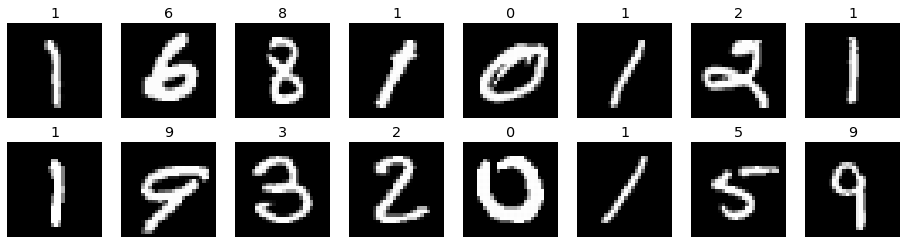

In [ ]:
#%matplotlib_inline
def PlotBatch(data_loader, batch_size = 16):
  batch = next(iter(data_loader))  # first batch of data_loader
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    style.use('ggplot')
    fig.add_subplot(2,8,i+1)
    temp = batch[i,1:]
    plt.imshow(temp.reshape(28,28), cmap='gray')
    plt.title(batch[i,0].item())
    plt.axis('off')


PlotBatch(train_dataloader)

In [ ]:
def return_params(device, dropout):
    '''
    all params1, params2, params3 are lists.
    my model will be
    conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size=(3,3), stride = (1,1), padding=(1,1))
    pool = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
    conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
    fc = nn.Linear(16*7*7, num_classes)
    '''
    params1 = init_conv_params(in_channels=1, out_channels=8,  kernel_size=(3,3), device=device)
    params2 = init_conv_params(in_channels=8, out_channels=16, kernel_size=(3,3), device=device)
    params3 = init_dense_params(in_nodes=16*7*7, out_nodes=10, device=device)
    #params = params1 + params2 + params3 # i will store my parameters as torch tensors which requires grad, 
    # required for giving arguments to optimizer for updating 
    return [params1, params2, params3]

In [ ]:
def model(x, params, device, dropout=True):
    '''
    shape of x will be - (batch_size, num_channels, height, width)
    '''
    # remember x must be casted to device and x must be a tensor, so first form data and dataloaders
    x = x.to(device) # casting to the device
    #print("op.shape = ", x.shape)
    op = conv_batch(x, params=params[0], pad_size=(1,1), stride=(1,1), device=device)
    #print("op.shape = ", op.shape)
    op = pool_batch(op, kernel_size=(2,2), pad_size=(0,0), stride=(2,2), mode='max', device=device)
    #print("op.shape = ", op.shape)
    op = conv_batch(op, params=params[1], pad_size=(1,1), stride=(1,1), device=device)
    #print("op.shape = ", op.shape)
    op = pool_batch(op, kernel_size=(2,2), pad_size=(0,0), stride=(2,2), mode='max', device=device)
    #print("op.shape = ", op.shape)
    # now i  have to flattten the input 
    op = torch.reshape(op, (op.shape[0], op.shape[1]*op.shape[2]*op.shape[3]))
    # now i have to pass the above output through the dense layer
    op = dense_batch(op, params=params[2], device=device, dropout=dropout)
    
    return op # shape must be (batch_size, num_classes)

# Initializing the parameters

In [ ]:
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
params = return_params(device, dropout=True)
optimizer = torch.optim.Adam(params=params[0]+params[1]+params[2], lr = lr)
criterion = torch.nn.CrossEntropyLoss()

# Training Loop

In [ ]:
x = torch.randn((32, 1, 28, 28), dtype=torch.float32)
a = model(x, params, device)

In [ ]:
a.shape

torch.Size([32, 10])

In [ ]:
def train(epoch, batch_size = 32, print_every = 20):
  total_loss = 0 # average of losses over all of the batches
  acc = []
  tic = time()

  for i, batch in enumerate(train_dataloader,1):  # i represents number of batches starting from 1
    model_input = (batch[:,1:]/255.0).to(device)
    model_input = model_input.reshape((model_input.shape[0], 1, 28, 28))
    target = (batch[:,0]).to(device)
    #print('model_input.shape = ', model_input.shape)
    model_output = model(model_input, params, device)
    #print('model_output.shape = ', model_output.shape)
    loss = criterion(model_output, target)
    total_loss+= loss.item()  # as it is just a tensor of 0 dimension, so converting it to a scalar by .item() method
    # backpropoagation
    optimizer.zero_grad() # making the gradients equal to zero if there are previously any
    loss.backward()
    optimizer.step()  # updating the gradients

    res = model_output.argmax(dim=1)
    acc.append((res==target).sum().item()/batch_size) # accuracy over a batch

    if i%print_every==0:   # should print something after every 'print_every' no. of batches are processed
      print('Epoch [{}] ({}/{}), train_loss = {:.4f}, accuracy = {:.2f}, time = {:.2f} sec'.format(epoch, i, len(train_dataloader), loss.item(), sum(acc)/len(acc), time() - tic ))
  return total_loss/len(train_dataloader) # returns average loss of all batches


In [ ]:
def test(epoch, batch_size = 32, print_every = 50):
  total_loss = 0
  acc = []
  tic = time()
  
  with torch.no_grad():
    for i, batch in enumerate(test_dataloader, 0):
      model_input = (batch[:,1:]/255.0).to(device)
      target = (batch[:,0]).to(device)
      model_input = model_input.reshape((model_input.shape[0], 1, 28, 28))

      model_output = model(model_input)
      loss = criterion(model_output, target)
      total_loss+= loss.item()

      result = model_output.argmax(dim=1)
      acc.append((result==target).sum().item()/target.shape[0]) 
  print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch+1, total_loss/len(test_dataloader), sum(acc)/len(acc), time()-tic
    ))
  return total_loss/len(test_dataloader) # Returning Average Testing Loss

# Final Training

In [33]:
train_loss = []
test_loss = []
for epoch in range(1, 2):
  train_loss.append(train(epoch, batch_size=32, print_every=1))
  test_loss.append(test(epoch, batch_size=32, print_every=1))
  print("\n")

model_input.shape =  torch.Size([32, 1, 28, 28])
model_output.shape =  torch.Size([32, 10])
Epoch [1] (1/1050), train_loss = 4.6850, accuracy = 0.25, time = 56.26 sec
model_input.shape =  torch.Size([32, 1, 28, 28])
model_output.shape =  torch.Size([32, 10])
Epoch [1] (2/1050), train_loss = 4.0380, accuracy = 0.25, time = 111.31 sec
model_input.shape =  torch.Size([32, 1, 28, 28])
model_output.shape =  torch.Size([32, 10])
Epoch [1] (3/1050), train_loss = 5.0845, accuracy = 0.21, time = 166.65 sec
model_input.shape =  torch.Size([32, 1, 28, 28])
model_output.shape =  torch.Size([32, 10])
Epoch [1] (4/1050), train_loss = 4.8763, accuracy = 0.17, time = 220.42 sec
model_input.shape =  torch.Size([32, 1, 28, 28])
model_output.shape =  torch.Size([32, 10])
Epoch [1] (5/1050), train_loss = 4.4767, accuracy = 0.18, time = 274.20 sec
model_input.shape =  torch.Size([32, 1, 28, 28])
model_output.shape =  torch.Size([32, 10])
Epoch [1] (6/1050), train_loss = 3.9240, accuracy = 0.17, time = 327.

KeyboardInterrupt: ignored

### Working very slow, so i will use standard nn class, but this can be a implementation